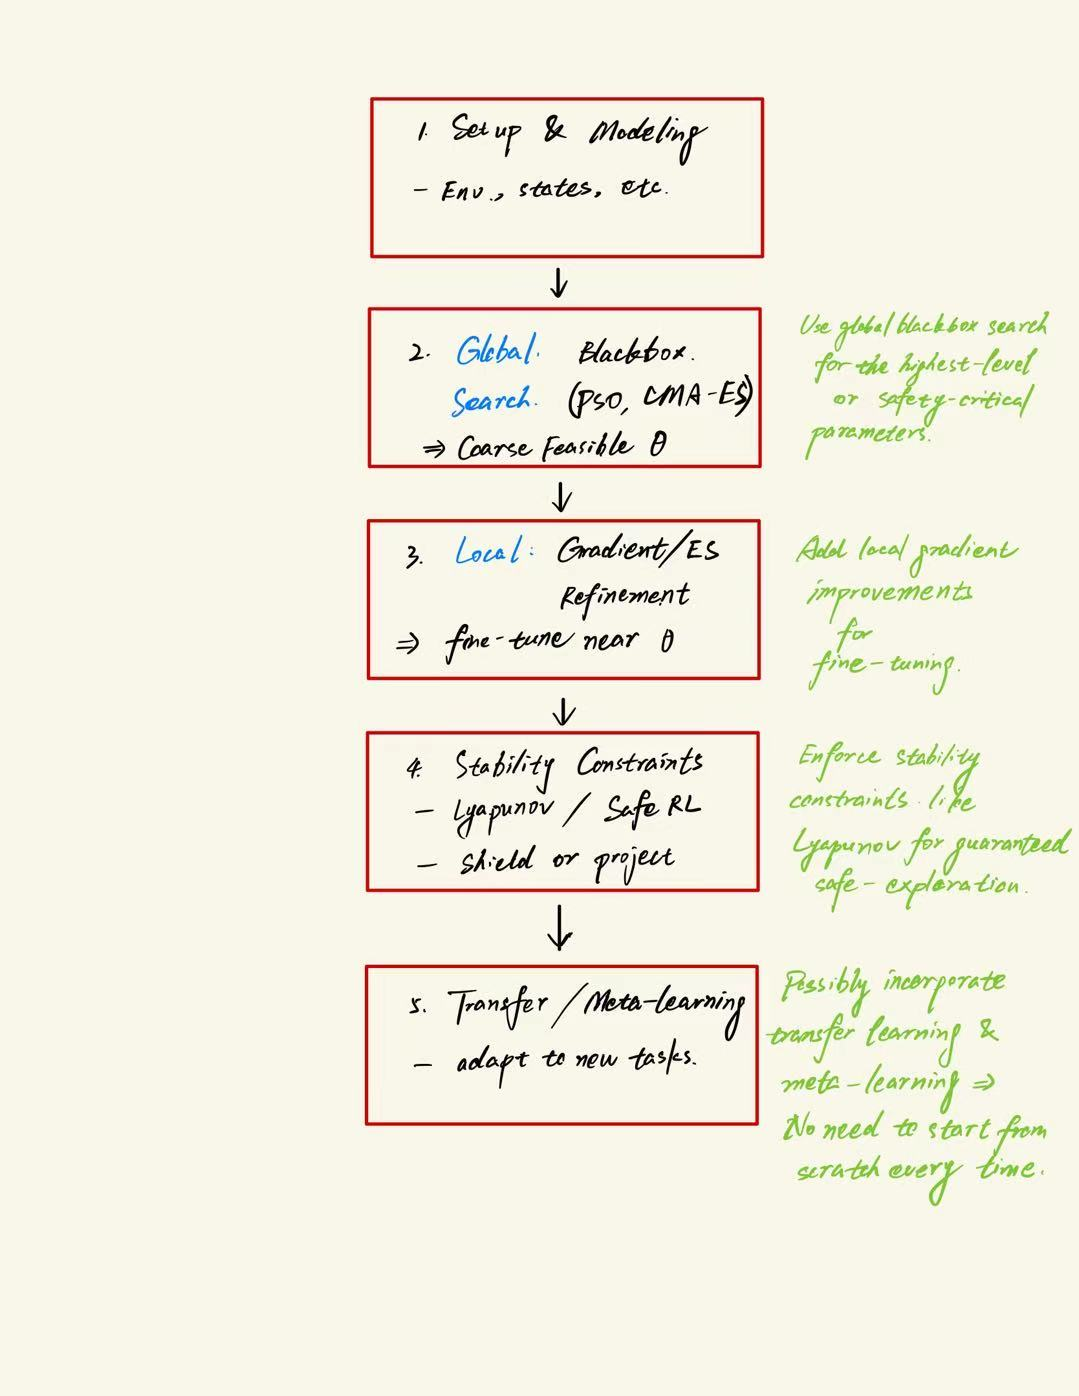

<span style="color:red">**I. Problem Setup & Modeling**</span>

1. Define the environment: (Two simulation experiments)
   * Simple System - single CSTR/ SISO
   * Complex System - large MIMO
   * Create a GYM environment:
     * observation $x_t$: states, setpoints, measurements
     * action $u_t$ or $K$: PID gains or direct control
     * reward $r_t$: tracking error + actuation penalty + constraints (or penalty terms for safety)
    
2. Controller-in-the-loop:
   * RL policy: outputs PID gains / direct manipulated variables (fit to existing PID)
   * If consider multiple loop problems, the policy can output ${(K_p, \tau_i, \tau_d)}_1, ..., {(K_p, \tau_i, \tau_d)}_m$ for m loops, or a vector of direct control actions.
   * In the environment:
     * Apply PID routine (gains), or
     * Directly set the actuation (direct control)
    
3. Constraints & Safety:
   * Identify physical constraints on states and manipulated variables (Temperature, flow, volume, etc.)
   * How to handle?
     * Hard clamping (clip in the environment)
     * Constraint penalty in the reward
     * Barrier Functions in a future step
    

<span style="color:red">**II. Global Blackbox Search for Feasible or Coarse Solutions**</span>

1. Motivation
   * We want an initial set of parameters $\theta$ (RL policy weights) that yields stable, feasible control and a decent cost/reward. => importance of initial guess
   * We do global blackbox search => avoid local minima or bad local optima in early stage
  
2. Algorithm selection:
   * criteria: sample efficiency, fast, global method
   * ParticleSwarmOptimizer (PSO), Covariance matrix adaptation evolution strategy (CEA-ES), or Bayesian Optmization, and many others
   * After a certain number of iterations or when improvement stalls, pick the best solution
  
3. Outputs:
   * A "good" / "coarse" / "mid-quality": $\theta_{global}$
   * Possibly: a region of parameter space that worked well

  
<span style="color:red">**III. Local Gradient Improvement**</span>

1. Initialize from $\theta_{global}$

2. Local Gradient Method:
   * motivation: faster & guaranteed
   * Option 1: Policy Gradient (PPO, TRPO, etc.) - updates after each episode or batch
   * Option 2: A derivative-free ES that uses finite-difference gradient estimates but starts near $\theta_{gloabal}$
   * Option 3: Hybrid approach - quasi-Newton for black functions or local MAML updates

3. Refining Process:
   * Because we are starting from a decent $\theta$, the local gradient method can quickly converge or refine near the region
   * Likely get better sample efficiency than purely global search, especially when the environment is costly to simulate

4. Reward function adjustments:
   * Possibly: add more refined penalties for overshoot, actuator usage, etc.
  

<span style="color:red"> **IV. Enforce Stability Constraints (Lyapunov / Safe Exploration)** </span>

1. Lyapunov or Barrier Function
   * If policy outputs PID gains within safe region, we can limit the search to that region (but this requires expert knowledge)
   * For direct control, incorporate control barrier functions to ensure states remain in a safe set
  
2. Implementation steps:
   1). After each update to $\theta$, project ot a set that ensures stability
   2). Add a exponential term to reward function if the closed-loop system violates a known stability condition
   3). Shielding: If RL policy tries to produce an "unsafe" action, we need to find a way to override it with a safe backup controller

3. Outcome (ideally)
   * The policy is refined only within stable or near-stable parameters, ensuring process never goes out of bounds
   * This part can be integrated into the local gradient step -- constraint policy gradient / safe ES
  
<span style="color:red"> **V. Transfer Learning / Meta-Learning** </span>

1. When
   * Have multiple related/similar tasks (setpoint tracking with different setpoints)
   * Want to adapt quickly without re-running the entire global + local search from scratch => important for chemical industries (especially those who use Factory settings for PIDs)
  
2. Techniques
   * Pre-training: Train the policy across a distribution of tasks or parameter variations. The final policy can handle these variations or adapt quickly.
   * Fine-tuning: For a new but similar system, start from old policy $\theta_{old}$ and do a shorter local update
   * Meta-RL: The policy is trained to adapt in juts a few steps if the environment changes
  
3. In chemical engineering settings:
   * Different operating regimes (low load vs. high load)
   * Continuous changing setpoints (for multi-grade manufacturing / multi-period operation)
   * Distillation column with high variance of feed composition

# Test code

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import gymnasium as gym
from gymnasium import spaces

# For Bayesian Optimization
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args

# For PPO local refinement
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.policies import BasePolicy
from stable_baselines3.common.distributions import DiagGaussianDistribution

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='stable_baselines3')

from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args

from stable_baselines3 import PPO

In [2]:
###########################################################################
# 1) SISO ENVIRONMENT WITH P and I
###########################################################################

class SISOEnv(gym.Env):
    """
     Discrete-time SISO environment with integral state:
      x_{k+1} = alpha*x_k + beta*u_k

    Observation = [x, e_int], where:
      - x is the current process variable,
      - e_int accumulates the tracking error e = (x_set - x).

    Action in [-1,1], mapped to [-5,5].

    Reward = -( 10*(error^2) + 0.01*(u^2) ).
      i.e. heavier emphasis on accurate setpoint tracking,
           smaller penalty on control usage.
    """
    def __init__(self, alpha=0.1, beta=0.9, horizon=100, x_set=1.0):
        super().__init__()

        self.alpha = alpha
        self.beta = beta
        self.horizon = horizon
        self.x_set = x_set

        # observation space: x in [-5, 5], e_int in [-50, 50]
        self.observation_space = spaces.Box(
            low = np.array([-5, -50], dtype=np.float32),
            high = np.array([5, 50], dtype=np.float32)
        )

        # actions: [-1, 1] ampped to [-5, 5]
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.t = 0
        self.x = 0.0
        self.e_int = 0.0   # integrator state
        self.done = False
        return self._get_obs(), {}

    def _get_obs(self):
        return np.array([self.x, self.e_int], dtype=np.float32)

    def step(self, action):
        # Flatten action in case it arrives as a float
        action = np.array(action, dtype=float).flatten()
        # Map [-1,1] => [-5,5]
        u = 5.0 * action[0]

        # Current tracking error
        e = self.x_set - self.x
        self.e_int += e  # integrate

        # System update
        x_next = self.alpha*self.x + self.beta*u
        self.x = x_next

        self.t += 1
        if self.t >= self.horizon:
            self.done = True

        # Cost: heavier penalty on error^2, smaller on u^2
        cost = 10*(e**2) + 0.01*(u**2)
        reward = -cost

        return self._get_obs(), reward, self.done, False, {}

In [3]:
###########################################################################
# 2) QUICK ENV CHECK
###########################################################################

env_test = SISOEnv()
check_env(env_test, warn=True)

In [4]:
###########################################################################
# 3) LOW-D POLICY FOR BAYESIAN OPT 
#    Policy: a = tanh(W1*x + W2*e_int + B)
###########################################################################

def rollout_with_params(params, alpha=0.1, beta=0.9, horizon=100, x_set=1.0):
    """
    Evaluate policy: a = tanh(W1*x + W2*e_int + B) using full 2D observation.
    'params' => [W1, W2, B].
    Returns total reward.
    """
    W1, W2, B = params  # Unpack all three parameters
    env = SISOEnv(alpha=alpha, beta=beta, horizon=horizon, x_set=x_set)

    obs, _ = env.reset()
    total_r = 0
    done = False
    while not done:
        x, e_int = obs  # Use both observation components
        a = np.tanh(W1 * x + W2 * e_int + B)  # Policy with integral term
        obs, r, done, _, _ = env.step([a])
        total_r += r
    return total_r



In [5]:
###########################################################################
# 4) BAYESIAN OPT FOR GLOBAL SEARCH
###########################################################################

space = [
    Real(-10.0, 10.0, name='W1'),  # Weight for x
    Real(-10.0, 10.0, name='W2'),  # Weight for e_int
    Real(-10.0, 10.0, name='B'),   # Bias
]

@use_named_args(space)
def objective(**kwargs):
    W1 = kwargs['W1']
    W2 = kwargs['W2']
    B = kwargs['B']
    rew = rollout_with_params([W1, W2, B])  # Pass all three parameters
    return -rew  # Minimize negative reward

print("Running Bayesian Optimization for global param search...")
res_gp = gp_minimize(
    objective,
    dimensions=space,
    n_calls=30,
    n_initial_points=10,
    acq_func='EI',
    random_state=123
)
best_params = res_gp.x  
best_score = -res_gp.fun
print(f"Found best params (W1, W2, B)={best_params}, reward={best_score:.3f}")

Running Bayesian Optimization for global param search...
Found best params (W1, W2, B)=[-1.78151254581962, 1.5938859404522034, -7.200984747392309], reward=-12091.957


In [6]:
###########################################################################
# 5) PPO FOR LOCAL GRADIENT IMPROVEMENT
#   define a small policy net that uses the full 2D observation:
###########################################################################

class SmallMLP(nn.Module):
    def __init__(self, obs_dim=2, hidden=16, init_W1=None, init_W2=None, init_B=None):
        super().__init__()
        self.fc1 = nn.Linear(obs_dim, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.out = nn.Linear(hidden, 1)

        # initialize the first layer weights and biases from previous
        if init_W1 is not None and init_W2 is not None and init_B is not None:
            with torch.no_grad():
                # set the first layer weights
                self.fc1.weight[0, 0] = init_W1
                self.fc1.weight[0, 1] = init_W2
                # set the first layer bias
                self.fc1.bias[0] = init_B

    def forward(self, x):
        # x shape => (batch_size, obs_dim)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # final => tanh => action in [-1,1]
        return torch.tanh(self.out(x))

class CustomPolicy(BasePolicy):
    def __init__(self, observation_space, action_space, lr_schedule,
                 init_W1, init_W2, init_B, **kwargs):
        super().__init__(observation_space, action_space, features_extractor=None)
        self.lr_schedule = lr_schedule
        self.obs_dim = observation_space.shape[0]
        self.policy_net = SmallMLP(obs_dim=self.obs_dim,
                                   hidden=16,
                                   init_W1=init_W1,
                                   init_W2=init_W2,
                                   init_B=init_B)
        self.value_net = nn.Linear(self.obs_dim, 1)
        self.action_dist = DiagGaussianDistribution(1)

        # optional usage of the BayesOpt result, e.g. initialize
        # the first layer close to "W, B" if you want
        # (we won't do that in detail since now we have 16 hidden units).
        self._setup_model()

    def _setup_model(self):
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.lr_schedule(1))

    def forward(self, obs, deterministic=False):
        mean = self.policy_net(obs)  # shape (batch_size,1)
        mean = mean.squeeze(-1)      # shape (batch_size,)
        log_std = torch.zeros_like(mean)

        val = self.value_net(obs)
        val = val.squeeze(-1)
        return mean, val, log_std

    def _predict(self, observation, deterministic=False):
        mean, _, log_std = self.forward(observation)
        if deterministic:
            return mean.unsqueeze(-1)
        else:
            action = self.action_dist.sample(mean, log_std)
            return action.unsqueeze(-1)

    def evaluate_actions(self, obs, actions):
        mean, val, log_std = self.forward(obs)
        var = torch.exp(2 * log_std)

        # shape fix
        actions = actions.view(-1)

        log_prob = -((actions - mean)**2)/(2*var) - log_std - 0.5*np.log(2*np.pi)
        entropy = log_std + 0.5*np.log(2*np.pi*np.e)

        return val, log_prob, entropy

    def predict_values(self, obs):
        with torch.no_grad():
            _, val, _ = self.forward(obs)
            return val


# Create a single-env with x_set=1.0 for local PPO refinement
vec_env = DummyVecEnv([lambda: SISOEnv(x_set=1.0, horizon=100)])
init_W1, init_W2, init_B = best_params

policy_kwargs = dict(init_W1=init_W1, init_W2=init_W2, init_B=init_B)
model = PPO(
    policy=CustomPolicy,
    env=vec_env,
    policy_kwargs=policy_kwargs,
    n_steps=256,
    batch_size=64,
    verbose=0
)

print("Training PPO locally from BayesOpt initialization...")
model.learn(total_timesteps=3000)

Training PPO locally from BayesOpt initialization...


In [7]:
###########################################################################
# 6) Evaluate the final policy
###########################################################################

def evaluate_sb3_model(model, x_set=1.0):
    test_env = SISOEnv(x_set=x_set, horizon=100)
    obs, _ = test_env.reset()
    total_r = 0
    done = False
    while not done:
        act, _ = model.predict(obs, deterministic=True)
        obs, r, done, _, _ = test_env.step(act)
        total_r += r
    return total_r

final_reward = evaluate_sb3_model(model, x_set=1.0)
print(f"PPO final policy reward ~ {final_reward:.3f}")

PPO final policy reward ~ -163.408


In [8]:
###########################################################################
# 7) META-LEARNING
###########################################################################

meta_envs = [
    lambda: SISOEnv(x_set=0.5),
    lambda: SISOEnv(x_set=1.0),
    lambda: SISOEnv(x_set=2.0),
]
meta_venv = DummyVecEnv(meta_envs)

meta_model = PPO(
    policy=CustomPolicy,
    env=meta_venv,
    policy_kwargs=policy_kwargs,
    n_steps=256,
    batch_size=64,
    verbose=0
)

print("Meta-training on multiple setpoints [0.5, 1.0, 2.0] ...")
meta_model.learn(total_timesteps=3000)
meta_model.save("meta_model.zip")

# Now adapt quickly to x_set = 1.5
adapt_env = DummyVecEnv([lambda: SISOEnv(x_set=1.5, horizon=100)])
new_model = PPO.load("meta_model.zip", env=adapt_env)
print("Adapting policy quickly for new setpoint x_set=1.5 ...")
new_model.learn(total_timesteps=1000)

test_r = evaluate_sb3_model(new_model, x_set=1.5)
print(f"Final reward on new setpoint x_set=1.5 => {test_r:.3f}")

print("\nDone! This code demonstrates:")
print("1) An integrator in the environment's observation ([x, e_int]).")
print("2) A cost function that heavily penalizes tracking error (10*e^2).")
print("3) Bayesian Optimization + PPO for local refinement.")
print("4) Meta-training on multiple setpoints, then quick adaptation to x_set=1.5.")

Meta-training on multiple setpoints [0.5, 1.0, 2.0] ...
Adapting policy quickly for new setpoint x_set=1.5 ...
Final reward on new setpoint x_set=1.5 => -56.768

Done! This code demonstrates:
1) An integrator in the environment's observation ([x, e_int]).
2) A cost function that heavily penalizes tracking error (10*e^2).
3) Bayesian Optimization + PPO for local refinement.
4) Meta-training on multiple setpoints, then quick adaptation to x_set=1.5.


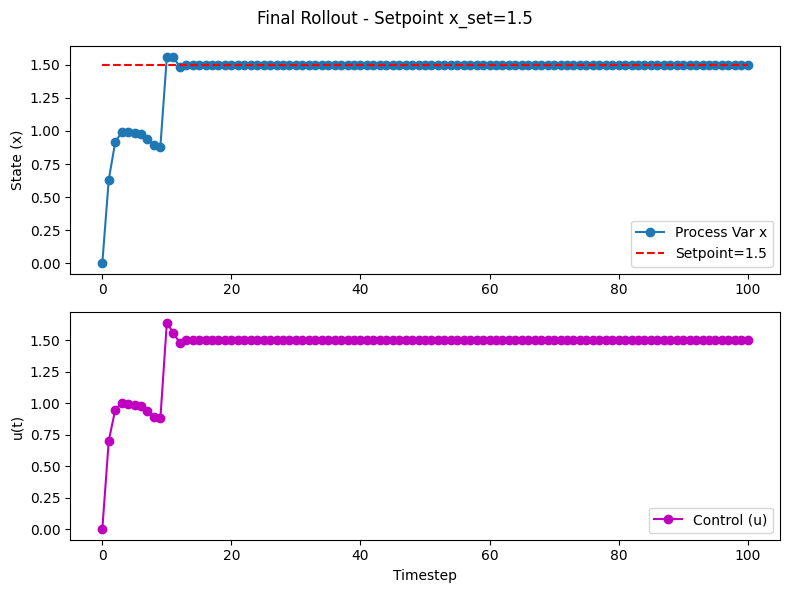

In [9]:
###########################################################################
# 8) PLOT THE FINAL ROLLOUT
###########################################################################
def plot_final_rollout(model, x_set=1.0, horizon=200):
    """
    Run a single rollout with the given model and setpoint,
    collect (x_t, u_t), and plot them.
    """
    env = SISOEnv(x_set=x_set, horizon=horizon)
    obs, _ = env.reset()

    xs = [env.x]
    us = [0.0]
    done=False

    while not done:
        act, _ = model.predict(obs, deterministic=True)
        a = np.array(act, dtype=float).flatten()[0]
        u = 5.0*a  # scale from [-1,1] => [-5,5]

        obs, r, done, _, _ = env.step(act)
        xs.append(env.x)
        us.append(u)

    ts = np.arange(len(xs))
    plt.figure(figsize=(8,6))
    plt.subplot(2,1,1)
    plt.plot(ts, xs, '-o', label='Process Var x')
    plt.hlines(x_set, 0, len(xs)-1, colors='r', linestyles='--', label=f'Setpoint={x_set}')
    plt.ylabel('State (x)')
    plt.legend()

    plt.subplot(2,1,2)
    plt.plot(ts, us, '-o', color='m', label='Control (u)')
    plt.ylabel('u(t)')
    plt.xlabel('Timestep')
    plt.legend()

    plt.suptitle(f"Final Rollout - Setpoint x_set={x_set}")
    plt.tight_layout()
    plt.show()

# Finally, show how well the adapted policy does on x_set=1.5
plot_final_rollout(new_model, x_set=1.5, horizon=100)


# Failed Test

Running Bayesian Optimization for global param search...
Found best params (W1, W2, B)=[-1.78151254581962, 1.5938859404522034, -7.200984747392309], reward=-513.871
Training PPO locally from BayesOpt initialization...
PPO final policy reward ~ -6726.995
Meta-training on multiple setpoints [1.0, 2.0, 0.5] ...
Adapting policy quickly for new setpoint x_set=1.5 ...
Final reward on new setpoint x_set=1.5 => -10735.257


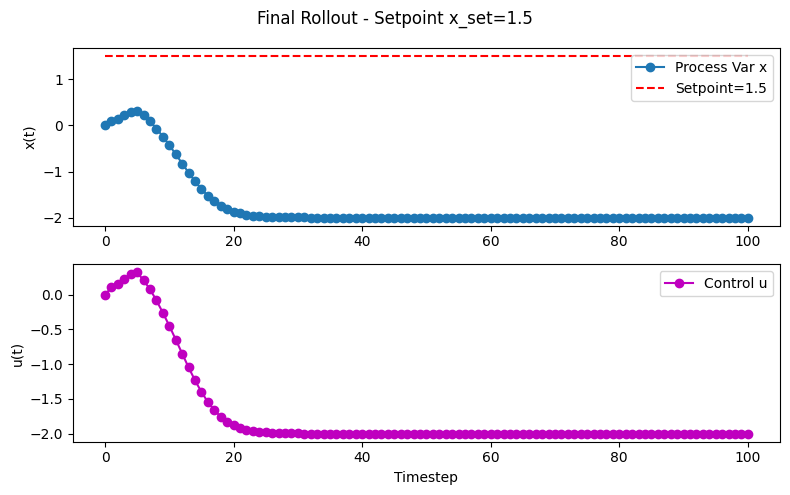

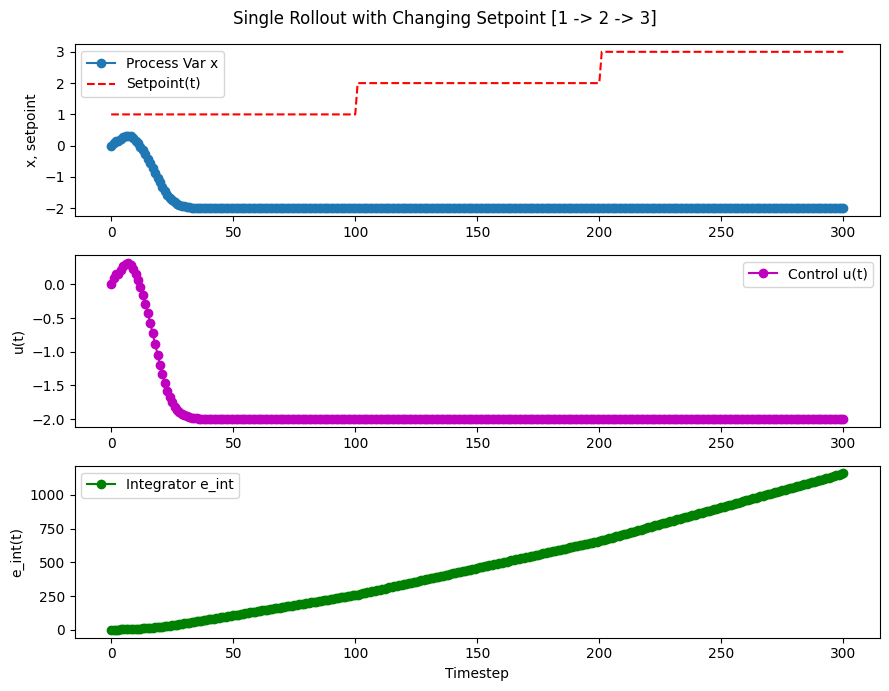

In [10]:
# !pip install stable-baselines3==2.0.0 scikit-optimize==0.9.0 gymnasium torch pyswarms --quiet

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt

# For Bayesian Optimization
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args

# For PPO (local refinement)
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.policies import BasePolicy
from stable_baselines3.common.distributions import DiagGaussianDistribution

###########################################################################
# 1) SISO ENVIRONMENT WITH P + I
###########################################################################
class SISOEnv(gym.Env):
    """
    Discrete-time SISO environment with integral state:
      x_{k+1} = alpha*x_k + beta*u_k

    Observation = [x, e_int], where:
      - x is the current process variable,
      - e_int accumulates tracking error e = (x_set - x).

    Action in [-1,1], mapped to [-5,5].

    Reward = -(10*(error^2) + 0.01*(u^2)).
    Focus is on accurate setpoint tracking with smaller penalty on control usage.
    """
    def __init__(self, alpha=0.1, beta=0.9, horizon=100, x_set=1.0):
        super().__init__()
        self.alpha   = alpha
        self.beta    = beta
        self.horizon = horizon
        self.x_set   = x_set

        # Obs = [x, e_int]
        self.observation_space = spaces.Box(
            low=np.array([-10, -50], dtype=np.float32),
            high=np.array([10,  50], dtype=np.float32),
        )
        # Action in [-1,1], mapped to [-2,2]
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)

        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.t = 0
        self.x = 0.0
        self.e_int = 0.0
        self.done = False
        return self._get_obs(), {}

    def _get_obs(self):
        return np.array([self.x, self.e_int], dtype=np.float32)

    def step(self, action):
        # Flatten action
        action = np.array(action, dtype=float).flatten()
        # Map [-1,1] => [-5,5]
        u = 2.0 * action[0]

        # tracking error
        e = self.x_set - self.x
        self.e_int += e

        # system update
        x_next = self.alpha*self.x + self.beta*u
        self.x = x_next

        self.t += 1
        if self.t >= self.horizon:
            self.done = True

        # cost
        cost = 10*(e**2) + 0.01*(u**2)
        reward = -cost

        return self._get_obs(), reward, self.done, False, {}

# Check environment
env_test = SISOEnv()
check_env(env_test, warn=True)

###########################################################################
# 2) Minimal "Policy" for Bayesian Optimization (a = tanh(W1*x + W2*e_int + B))
###########################################################################
def rollout_with_params(params, alpha=0.1, beta=0.9, horizon=100, x_set=1.0):
    """
    Evaluate policy: a = tanh(W1*x + W2*e_int + B), ignoring any hidden layers.
    'params' => [W1, W2, B].
    """
    W1, W2, B = params
    env = SISOEnv(alpha=alpha, beta=beta, horizon=horizon, x_set=x_set)
    obs, _ = env.reset()
    total_r = 0
    done = False
    while not done:
        x, e_int = obs
        a = np.tanh(W1*x + W2*e_int + B)
        obs, r, done, _, _ = env.step([a])
        total_r += r
    return total_r

# Set up Bayesian Optimization
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args

space = [
    Real(-10.0, 10.0, name='W1'),
    Real(-10.0, 10.0, name='W2'),
    Real(-10.0, 10.0, name='B'),
]

@use_named_args(space)
def objective(**kwargs):
    W1 = kwargs['W1']
    W2 = kwargs['W2']
    B  = kwargs['B']
    rew = rollout_with_params([W1, W2, B])
    return -rew

print("Running Bayesian Optimization for global param search...")
res_gp = gp_minimize(
    objective,
    dimensions=space,
    n_calls=30,
    n_initial_points=10,
    acq_func='EI',
    random_state=123
)
best_params = res_gp.x
best_score = -res_gp.fun
print(f"Found best params (W1, W2, B)={best_params}, reward={best_score:.3f}")

###########################################################################
# 3) PPO: Small MLP policy that uses full 2D observation
###########################################################################
class SmallMLP(nn.Module):
    def __init__(self, obs_dim=2, hidden=64, init_W1=None, init_W2=None, init_B=None):
        super().__init__()
        self.fc1 = nn.Linear(obs_dim, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.out = nn.Linear(hidden, 1)

        # Optionally initialize first layer with BayesOpt results
        if all(v is not None for v in [init_W1, init_W2, init_B]):
            with torch.no_grad():
                # place the discovered W1, W2 in row 0
                self.fc1.weight[0,0] = init_W1
                self.fc1.weight[0,1] = init_W2
                # bias
                self.fc1.bias[0] = init_B

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.out(x))

from stable_baselines3.common.policies import BasePolicy
from stable_baselines3.common.distributions import DiagGaussianDistribution

class CustomPolicy(BasePolicy):
    def __init__(self, observation_space, action_space, lr_schedule,
                 init_W1, init_W2, init_B, **kwargs):
        super().__init__(observation_space, action_space, features_extractor=None)
        self.lr_schedule = lr_schedule
        self.obs_dim = observation_space.shape[0]

        self.policy_net = SmallMLP(
            obs_dim=self.obs_dim,
            hidden=16,
            init_W1=init_W1,
            init_W2=init_W2,
            init_B=init_B
        )
        self.value_net = nn.Linear(self.obs_dim, 1)
        self.action_dist = DiagGaussianDistribution(1)
        self._setup_model()

    def _setup_model(self):
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.lr_schedule(1))

    def forward(self, obs, deterministic=False):
        mean = self.policy_net(obs)  
        mean = mean.squeeze(-1)      
        log_std = torch.zeros_like(mean)
        val = self.value_net(obs).squeeze(-1)
        return mean, val, log_std

    def _predict(self, observation, deterministic=False):
        mean, _, log_std = self.forward(observation)
        if deterministic:
            return mean.unsqueeze(-1)
        else:
            action = self.action_dist.sample(mean, log_std)
            return action.unsqueeze(-1)

    def evaluate_actions(self, obs, actions):
        mean, val, log_std = self.forward(obs)
        var = torch.exp(2*log_std)
        actions = actions.view(-1)

        log_prob = -((actions - mean)**2)/(2*var) - log_std - 0.5*np.log(2*np.pi)
        entropy = log_std + 0.5*np.log(2*np.pi*np.e)
        return val, log_prob, entropy

    def predict_values(self, obs):
        with torch.no_grad():
            _, val, _ = self.forward(obs)
            return val

# Create an env with x_set=1.0 for local PPO refinement
from stable_baselines3 import PPO

vec_env = DummyVecEnv([lambda: SISOEnv(x_set=1.0, horizon=100)])
init_W1, init_W2, init_B = best_params

policy_kwargs = dict(init_W1=init_W1, init_W2=init_W2, init_B=init_B)
model = PPO(
    policy=CustomPolicy,
    env=vec_env,
    policy_kwargs=policy_kwargs,
    n_steps=256,
    batch_size=64,
    verbose=0
)

print("Training PPO locally from BayesOpt initialization...")
model.learn(total_timesteps=3000)

def evaluate_sb3_model(model, x_set=1.0):
    test_env = SISOEnv(x_set=x_set, horizon=100)
    obs, _ = test_env.reset()
    total_r = 0
    done = False
    while not done:
        act, _ = model.predict(obs, deterministic=True)
        obs, r, done, _, _ = test_env.step(act)
        total_r += r
    return total_r

final_reward = evaluate_sb3_model(model, x_set=1.0)
print(f"PPO final policy reward ~ {final_reward:.3f}")

###########################################################################
# 4) META-LEARNING
###########################################################################
meta_envs = [
    lambda: SISOEnv(x_set=1.0),
    lambda: SISOEnv(x_set=2.0),
    lambda: SISOEnv(x_set=4.0),
]
meta_venv = DummyVecEnv(meta_envs)

meta_model = PPO(
    policy=CustomPolicy,
    env=meta_venv,
    policy_kwargs=policy_kwargs,
    n_steps=256,
    batch_size=64,
    verbose=0
)

print("Meta-training on multiple setpoints [1.0, 2.0, 0.5] ...")
meta_model.learn(total_timesteps=3000)
meta_model.save("meta_model.zip")

# Now adapt quickly to x_set=1.5
adapt_env = DummyVecEnv([lambda: SISOEnv(x_set=1.5, horizon=100)])
new_model = PPO.load("meta_model.zip", env=adapt_env)
print("Adapting policy quickly for new setpoint x_set=1.5 ...")
new_model.learn(total_timesteps=1000)

test_r = evaluate_sb3_model(new_model, x_set=1.5)
print(f"Final reward on new setpoint x_set=1.5 => {test_r:.3f}")

###########################################################################
# 5) PLOT A SINGLE-SETPOINT ROLLOUT (Basic)
###########################################################################
def plot_final_rollout(model, x_set=1.0, horizon=100):
    env = SISOEnv(x_set=x_set, horizon=horizon)
    obs, _ = env.reset()

    xs = [env.x]
    us = [0.0]
    done = False

    while not done:
        act, _ = model.predict(obs, deterministic=True)
        a = float(act[0])
        u = 2.0*a  # scale from [-1,1] => [-2,2]

        obs, r, done, _, _ = env.step(act)
        xs.append(env.x)
        us.append(u)

    ts = np.arange(len(xs))
    plt.figure(figsize=(8,5))
    plt.subplot(2,1,1)
    plt.plot(ts, xs, '-o', label='Process Var x')
    plt.hlines(x_set, 0, len(xs)-1, color='r', linestyles='--', label=f'Setpoint={x_set}')
    plt.ylabel("x(t)")
    plt.legend()

    plt.subplot(2,1,2)
    plt.plot(ts, us, '-o', c='m', label='Control u')
    plt.ylabel("u(t)")
    plt.xlabel("Timestep")
    plt.legend()
    plt.suptitle(f"Final Rollout - Setpoint x_set={x_set}")
    plt.tight_layout()
    plt.show()

# Example: see how well the adapted policy does on x_set=1.5
plot_final_rollout(new_model, x_set=1.5, horizon=100)


###########################################################################
# 6) ILLUSTRATION: CHANGING SETPOINT from 1 -> 2 -> 3
###########################################################################
class SISOEnvChangingSetpoint(SISOEnv):
    """
    Inherits from the SISOEnv but changes the setpoint every 'segment_length' steps.
    E.g. setpoints=[1,2,3], segment_length=100 => 300 steps total,
    from 0..99 => x_set=1, 100..199 => x_set=2, 200..299 => x_set=3.
    """
    def __init__(self, alpha=0.1, beta=0.9, horizon=300,
                 setpoints=[1.0, 2.0, 3.0], segment_length=100):
        # We start with x_set = setpoints[0], but will override in step()
        super().__init__(alpha=alpha, beta=beta, horizon=horizon, x_set=setpoints[0])
        self.setpoints = setpoints
        self.segment_length = segment_length

    def step(self, action):
        # figure out current setpoint based on t
        index = self.t // self.segment_length
        if index < len(self.setpoints):
            self.x_set = self.setpoints[index]
        else:
            # if t beyond total segments, stay at last setpoint
            self.x_set = self.setpoints[-1]

        return super().step(action)

def plot_changing_sp_rollout(model, setpoints=[1.0,2.0,3.0], horizon=300):
    """
    Single rollout with changing setpoint. We'll log (x, setpoint, u, e_int, etc.).
    """
    env = SISOEnvChangingSetpoint(horizon=horizon, setpoints=setpoints)
    obs, _ = env.reset()

    xs, us, sp_hist, e_ints = [], [], [], []
    xs.append(env.x)
    us.append(0.0)
    sp_hist.append(env.x_set)
    e_ints.append(env.e_int)

    done = False
    while not done:
        act, _ = model.predict(obs, deterministic=True)
        a = float(act[0])
        u = 2.0*a
        obs, r, done, _, _ = env.step(act)

        xs.append(env.x)
        us.append(u)
        sp_hist.append(env.x_set)
        e_ints.append(env.e_int)

    ts = np.arange(len(xs))
    plt.figure(figsize=(9,7))

    plt.subplot(3,1,1)
    plt.plot(ts, xs, '-o', label='Process Var x')
    plt.plot(ts, sp_hist, '--r', label='Setpoint(t)')
    plt.ylabel("x, setpoint")
    plt.legend()

    plt.subplot(3,1,2)
    plt.plot(ts, us, '-o', c='m', label='Control u(t)')
    plt.ylabel("u(t)")
    plt.legend()

    plt.subplot(3,1,3)
    plt.plot(ts, e_ints, '-o', c='g', label='Integrator e_int')
    plt.xlabel("Timestep")
    plt.ylabel("e_int(t)")
    plt.legend()

    plt.suptitle("Single Rollout with Changing Setpoint [1 -> 2 -> 3]")
    plt.tight_layout()
    plt.show()

# Demo: let's see how the "new_model" (the meta-adapted model) handles
# setpoint changes at t=0..99 => 1.0, t=100..199 => 2.0, t=200..299 => 3.0
plot_changing_sp_rollout(new_model, setpoints=[1.0, 2.0, 3.0], horizon=300)
